In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, log_loss, mean_squared_error
from sklearn.preprocessing import LabelBinarizer
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
from TrainTestData import loadData

from Features import FeatureColumns

pd.options.mode.chained_assignment = None

In [28]:
X_train, X_test, y_train, y_test, data, feature_columns, categorical_features,target_column = loadData()

In the preprocessing stage of our multi-class classification pipeline, we employ a crucial step of transforming categorical target variables into a numerical format. This transformation is essential for compatibility with XGBoost, a gradient boosting framework that requires numerical input to perform mathematical operations and optimizations integral to its learning algorithm (Chen & Guestrin, 2016).
XGBoost, like many machine learning algorithms, operates on numerical data to execute arithmetic operations, gradient calculations, and optimization procedures. These operations are not inherently defined for categorical data, necessitating a transformation of categorical labels into a numerical representation (Bishop, 2006).
Specifically, for a multi-class classification problem, each unique categorical class label is assigned a unique integer value, a process known as label encoding. This procedure transforms the categorical target variable into a format amenable to the mathematical computations required by XGBoost (Hastie, Tibshirani, & Friedman, 2009).
For a dataset with \(C\) unique classes, label encoding maps each class to a unique integer in the range \([0, C-1]\). This approach is both efficient and straightforward, ensuring that the transformed target variable retains the essential categorical information in a numerical format compatible with XGBoost's requirements (James, Witten, Hastie, & Tibshirani, 2013).
Upon transformation, XGBoost utilizes the numerical labels to compute a multi-class log loss (cross-entropy loss) when the `multi:softprob` or `multi:softmax` objective function is specified. This loss function quantifies the difference between the predicted probabilities and the actual class labels, guiding the model's learning process (Friedman, 2001).
The transformation of categorical data into numerical form is supported by the foundational principles of statistical learning, which emphasize the necessity of numerical representation for the application of mathematical models to data analysis and prediction tasks (Bishop, 2006; Hastie, Tibshirani, & Friedman, 2009). Furthermore, research by Chen and Guestrin (2016) on XGBoost highlights the effectiveness of gradient boosting machines for various tasks, including multi-class classification, when data is appropriately preprocessed and encoded.
Data transformation step is not merely a technical requirement but a scientifically grounded practice that enhances the ability of XGBoost to accurately model and predict outcomes in multi-class classification settings. By converting categorical labels into a numerical format, we align our dataset with the underlying mathematical framework of machine learning algorithms, facilitating efficient and effective model training and prediction.

In [29]:
#initialise coder and classifier
xgb_clf = XGBClassifier(objective="multi:softprob",use_label_encoder=False, eval_metric='mlogloss')
label_encoder = LabelEncoder()

label_encoder.fit(y_train)
#y_test = label_encoder.transform(y_test)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

Recursive Feature Elimination (RFE) is an effective method for feature selection that can enhance the performance of predictive models in statistics and machine learning. This technique aims to identify the most predictive features by successively removing the least important ones. The process starts with the complete set of features and iteratively eliminates the least significant feature, based on the model criterion chosen, until a predetermined number of features is reached or the model performance reaches an optimum.

A key aspect of RFE is its ability to derive feature importance directly from the coefficients of models that provide intrinsic feature weightings, such as linear models and Support Vector Machines (Guyon et al., 2002). By incorporating Cross-Validation (CV) into the RFE process, known as RFECV, the robustness of feature selection is further enhanced by accounting for the variability of model performance across different data splits (Kohavi, 1995).

The application of RFE can offer value across numerous domains, from bioinformatics to financial modeling, by not only improving model performance through the reduction of overfitting and enhancement of generalizability but also contributing to the interpretability of the models by highlighting the most relevant features.

Optimale Anzahl von Merkmalen: 30
Ausgewählte Merkmale und deren Rankings:
X: Rang 1
Y: Rang 1
Min.TemperatureF: Rang 1
Mean.TemperatureF: Rang 1
Max.TemperatureF: Rang 1
Mean.Humidity: Rang 1
DayOfWeek_Friday: Rang 1
DayOfWeek_Monday: Rang 2
DayOfWeek_Saturday: Rang 1
DayOfWeek_Sunday: Rang 1
DayOfWeek_Thursday: Rang 1
DayOfWeek_Tuesday: Rang 1
DayOfWeek_Wednesday: Rang 1
PdDistrict_BAYVIEW: Rang 1
PdDistrict_CENTRAL: Rang 1
PdDistrict_INGLESIDE: Rang 1
PdDistrict_MISSION: Rang 1
PdDistrict_NORTHERN: Rang 1
PdDistrict_PARK: Rang 1
PdDistrict_RICHMOND: Rang 1
PdDistrict_SOUTHERN: Rang 1
PdDistrict_TARAVAL: Rang 4
PdDistrict_TENDERLOIN: Rang 1
Events_Clear: Rang 1
Events_Fog: Rang 1
Events_Fog-Rain: Rang 1
Events_Rain: Rang 1
Events_Rain-Thunderstorm: Rang 1
Events_Thunderstorm: Rang 3
season_Autumn: Rang 1
season_Spring: Rang 1
season_Summer: Rang 1
season_Winter: Rang 1


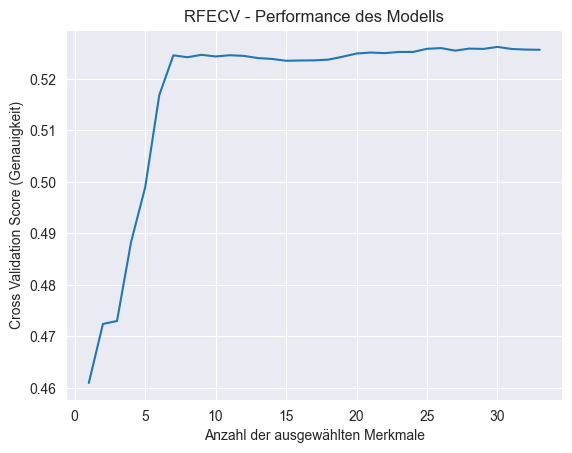

In [25]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
# RFECV vorbereiten
cv_strategy = StratifiedKFold(n_splits=4)
rfecv = RFECV(estimator=xgb_clf, step=1, cv=cv_strategy, scoring='accuracy')

# RFECV on train data
rfecv.fit(X_train, y_train_encoded)

# Output the results of the feature selection
print("Optimal number of features: %d" % rfecv.n_features_)

# Extracting the feature names based on RFECV support
selected_features = X_train.columns[rfecv.support_]

# Output of the selected feature names and their rankings
print("Selected features and their rankings:")
for rank, feature in zip(rfecv.ranking_, X_train.columns):
    print(f"{feature}: Rank {rank}")

# Plot
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross Validation Score (Accuracy)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.title('RFECV - Performance of the model')
plt.show()


In [26]:
from sklearn.model_selection import cross_validate

# Scoring-Kriterien definieren
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'roc_auc_ovr': 'roc_auc_ovr'
}

# Kreuzvalidierung mit mehreren Metriken
cv_results = cross_validate(xgb_clf, X_train, y_train_encoded, cv=4, scoring=scoring, return_train_score=False)

# Ergebnisse ausgeben
for metric in scoring.keys():
    print(f"Average {metric}: {np.mean(cv_results[f'test_{metric}']) * 100:.2f}%")
    print(f"Standard deviation {metric}: {np.std(cv_results[f'test_{metric}']) * 100:.2f}%")

Durchschnittliche accuracy: 52.57%
Standardabweichung accuracy: 0.14%
Durchschnittliche f1_macro: 35.51%
Standardabweichung f1_macro: 0.24%
Durchschnittliche roc_auc_ovr: 74.40%
Standardabweichung roc_auc_ovr: 0.05%


In [31]:
# Training des Classifiers
xgb_clf.fit(X_train, y_train_encoded)

# Vorhersagen auf dem Testset
y_pred = xgb_clf.predict(X_test)

# Vorhersagen der Wahrscheinlichkeiten für das Testset, um ROC-AUC und Log Loss zu berechnen
y_pred_proba = xgb_clf.predict_proba(X_test)

# Berechnung der verschiedenen Metriken
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' berücksichtigt Label-Unausgewogenheit
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

# ROC-AUC Score erfordert binarisierte Labels für Mehrklassenklassifikation
lb = LabelBinarizer()
lb.fit(y_test)
y_test_binarized = lb.transform(y_test)
y_pred_binarized = lb.transform(y_pred)

roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovo', average='weighted')
logloss = log_loss(y_test, y_pred_proba)

# Ausgabe der Metriken
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")

ValueError: Mix of label input types (string and number)

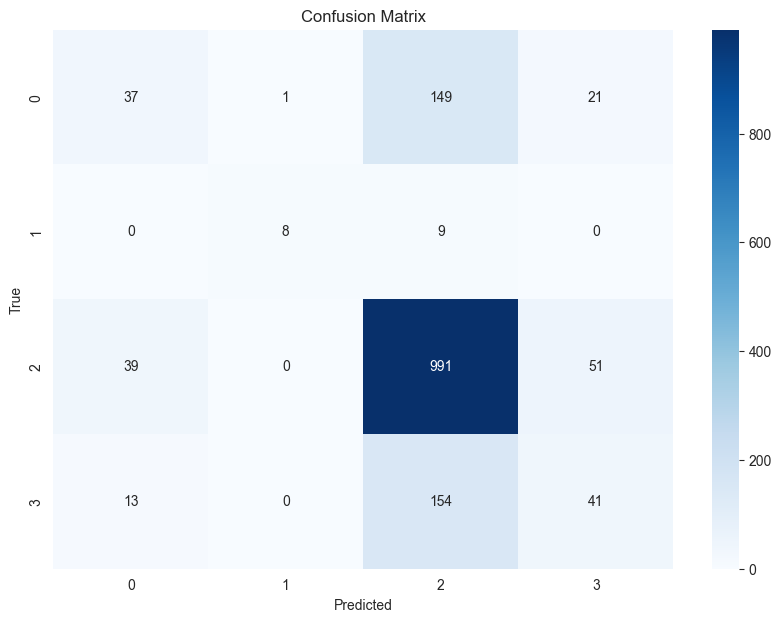

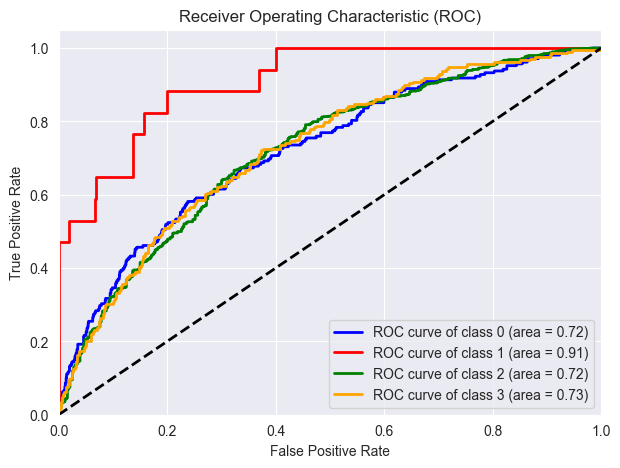

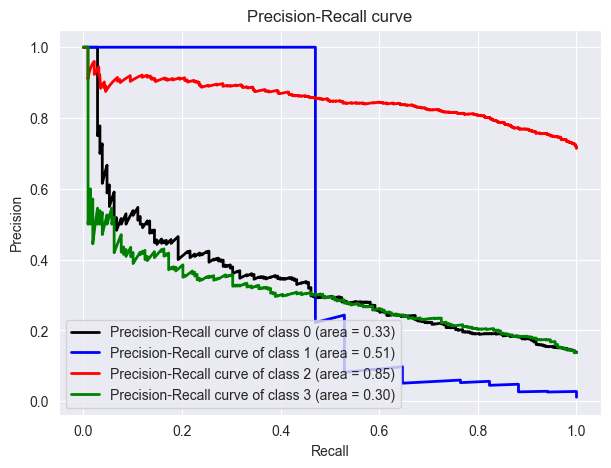

In [4]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Die Confusion Matrix ist eine grundlegende und sehr informative Visualisierung,
# die zeigt, wie gut das Modell die verschiedenen Klassen unterscheidet.
# Sie gibt die Anzahl der korrekten und falschen Vorhersagen für jede Klasse an und hilft,
# die Bereiche zu identifizieren, in denen das Modell möglicherweise verbessert werden muss

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Die Receiver Operating Characteristic (ROC)-Kurve und die Area Under the Curve (AUC)
# sind besonders nützlich für binäre Klassifizierungsprobleme.
# Sie können auch für Mehrklassenprobleme angepasst werden,
# indem man die One-vs-All-Strategie für jede Klasse anwendet.
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Farben für die verschiedenen Klassen
colors = cycle(['blue', 'red', 'green', 'orange', 'black'])

# Plotten der ROC-Kurve für jede Klasse
plt.figure(figsize=(7, 5))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Berechnung für jede Klasse
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i],
                                                        y_pred_proba[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])

# Die Precision-Recall-Kurve ist eine weitere nützliche Visualisierung, 
# besonders in Situationen, in denen die Klassen stark unausgeglichen sind. 
# Sie zeigt das Verhältnis von Precision (Präzision) und Recall (Sensitivität) für verschiedene Schwellenwerte.
plt.figure(figsize=(7, 5))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-Recall curve of class {0} (area = {1:0.2f})'
             ''.format(i, average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()


**References:**

- T. Chen & C. Guestrin (2016). XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining.
- C.M. Bishop (2006). Pattern Recognition and Machine Learning. Springer.
- T. Hastie, R. Tibshirani, & J. Friedman (2009). The Elements of Statistical Learning: Data Mining, Inference, and Prediction. Springer Series in Statistics.
- G. James, D. Witten, T. Hastie, & R. Tibshirani (2013). An Introduction to Statistical Learning: with Applications in R. Springer Texts in Statistics.
- J.H. Friedman (2001). Greedy Function Approximation: A Gradient Boosting Machine. The Annals of Statistics.
- Guyon, I., Weston, J., Barnhill, S., & Vapnik, V. (2002). Gene selection for cancer classification using support vector machines. Machine Learning, 46(1-3), 389-422.
- Kohavi, R. (1995). A study of cross-validation and bootstrap for accuracy estimation and model selection. IJCAI'95: Proceedings of the 14th international joint conference on Artificial intelligence, 2(12), 1137-1145.
- Databasecamp. (2023) https://databasecamp.de/statistik/f1-score